# How bias changes with training data

Notebook contents:
1. Bias metrics in the existing literature
2. Training of word2vec on different training datasets (of varying sizes and sources)
3. Visualizations and computations of bias metrics

## 1. Bias metrics in the existing literature

There are 3 prominent metrics in the literature (among others): projection of word embeddings along a gender direction (Bolukbasi, modified by Nissim), WEAT, and WEFAT (Caliskan, Bryson, Narayanan). Below we summarize these papers.

#### 1. Bolukbasi et al. (NIPS 2016): "Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings" https://arxiv.org/abs/1607.06520

#### 2. Nissim, van Noord, and van der Goot (2019): "Fair is Better than Sensational: Man is to Doctor as Woman is to Doctor" https://arxiv.org/abs/1905.09866

#### 3. Caliskan, Bryson, and Narayanan (Science 2017): "Semantics derived automatically from language corpora contain human-like biases" https://purehost.bath.ac.uk/ws/portalfiles/portal/168480066/CaliskanEtAl_authors_full.pdf

* IAT is one technique used (outside of word embeddings) to measure implicit human biases:
    * "Implicit Association Test": assessment (on humans) introduced by Greenwald et al., where a word is categorized into one of two categories, and faster reaction time is considered as more deeply rooted association
* Introduces new statistical test **WEAT** (Word Embedding Association Test) to measure biases in word embeddings
    * analogous to the IAT: interpretation is "how separated the two distributions (of associations between target and attribute) are"
    * inputs:
        * 2 sets of target words:
            * X. programmer/engineer/scientist/...
            * Y. nurse/teacher/librarian/...) 
        * 2 sets of attribute words:
            * A. man/male/...
            * B. woman/female/...):
    * test statistic:
        * intuitively, difference between association of two sets of target words, with attributes
        * $s(X, Y, A, B) = \sum_{x \in X} s(x, A, B) - \sum_{y \in Y} s(y, A, B)$
        * $s(w, A, B) = mean_{a \in A} cos(w, a) - mean_{b \in B} cos(w, b)$
    * p-value of permutation test (permuting target words)
        * $Pr_i[s(X_i, Y_i, A, B) > s(X, Y, A, B)]$
        * effect size: $\frac{mean_{x \in X} s(x, A, B) - mean_{y \in Y} s(y, A, B)}{sd_{w \in X \bigcup Y} s(w, A, B)}$
    * Obtains similar results to original finding in Greenwald et al.
* Introduces **WEFAT** (Word Embedding Factual Association Test):
    * instead of using target word embeddings, use real-valued factual property, e.g. % female workers in occupation)
    * difference in avg. cos similarity (between attribute A and target property, vs. attribute B and target property), divided by standard deviation of cos similarity (across each combination of attribute - target property) 
    * high correlation between % of women in different occupations, vs. strength of association of word vector w/ female gender

## 2. word2vec model training

Dataset grid: 20 datasets

Training size:
* 25%
* 50%
* 75%
* 100%

Source:
* TweetEval: labeled tweet dataset (e.g. sentiment, hate, emotion): https://huggingface.co/datasets/tweet_eval
* Reddit: unlabeled reddit post dataset: https://huggingface.co/datasets/reddit
* CNN/DailyMail: news article text with highlights: https://huggingface.co/datasets/cnn_dailymail
* Pretrained historical word vectors: pre-trained word vectors trained on historical books from various decades from 1880s - 1990s: https://nlp.stanford.edu/projects/histwords/
* The New York Times Annotated Corpus: articles with metadata from 1987-2007: https://catalog.ldc.upenn.edu/LDC2008T19

In [16]:
DATA = "cnn_dailymail"

In [17]:
from datasets import load_dataset
from os.path import exists
import numpy as np
import random

# Set seed for random subsetting of data (to reduce training set to make training feasible)
random.seed(1)

if DATA == "tweet_eval":
    dataset = load_dataset(DATA, "hate")
    X_train = dataset['train']['text']
    X_train = [i.replace('@user', '') for i in X_train] #strip @ mentions
elif DATA == "reddit":
    dataset = load_dataset(DATA)
    X_train = dataset['train']['text']
elif DATA == "cnn_dailymail":
    dataset = load_dataset(DATA, '3.0.0')
    X_train = dataset['train']['article']
    X_train = random.sample(X_train, 5000)

EMBEDDINGS_FILE = f'{DATA}_embeddings.npy'

# Load trained embeddings, if exists
if exists(EMBEDDINGS_FILE):
    learned_embeddings = np.load(EMBEDDINGS_FILE)
    print(f"Loaded local embeddings with shape: {learned_embeddings.shape}")

Reusing dataset cnn_dailymail (/home/morrisreeves/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


  0%|          | 0/3 [00:00<?, ?it/s]

Loaded local embeddings with shape: (5000, 100)


## Text preprocessing functions:

In [23]:
from typing import Tuple, Dict, List
import re

punc = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~—“”'

def remove_punc(text: str, punc: str) -> str:
    return text.translate({ord(p):'' for p in punc})

def split_on_whitespace(text: str) -> List[str]:
    if text: return re.split('\s+', text)
    else: return []

def tokenize(text: str, punc: str) -> List[str]:
    return [i for i in split_on_whitespace(remove_punc(text, punc).lower()) if i]

def load_corpus(texts: List[str], punc: str) -> List[List[str]]:
    tokenized_docs = []
    for t in texts:
        tokenized_docs.append(tokenize(t, punc))
    return tokenized_docs

In [29]:
# list of lists (of tokens): each element of the list is a document (e.g. tweet, news article, etc.)
full_tokenized = load_corpus(X_train, punc)
print(full_tokenized[0][:10])

['colombo', 'sri', 'lanka', 'cnn', 'a', 'sri', 'lanka', 'politician', 'ended', 'his']


## Gensim package implementation of CBOW:

In [30]:
from gensim.models import Word2Vec

In [32]:
model = Word2Vec(sentences=full_tokenized, size = 100, window=5, min_count=5, workers=4)

In [39]:
# Sense checking the trained word vectors using gensim's built-in methods...
model.wv.most_similar(positive=["man"], topn=10)

[('woman', 0.8530028462409973),
 ('boy', 0.771740198135376),
 ('girl', 0.7681539058685303),
 ('teenager', 0.7364521026611328),
 ('himself', 0.7291650772094727),
 ('driver', 0.7270429134368896),
 ('person', 0.693087637424469),
 ('doctor', 0.6928565502166748),
 ('soldier', 0.688307523727417),
 ('dog', 0.6637560129165649)]

In [40]:
model.wv.most_similar(positive=["monday"], topn=10)

[('tuesday', 0.9584875106811523),
 ('wednesday', 0.9520950317382812),
 ('thursday', 0.9432012438774109),
 ('friday', 0.9404246807098389),
 ('sunday', 0.8951826095581055),
 ('saturday', 0.8904947638511658),
 ('yesterday', 0.6942245364189148),
 ('board', 0.6639047265052795),
 ('arraigned', 0.6430783867835999),
 ('bail', 0.6226698160171509)]

## Manual implementation of CBOW:
(Borrowed from AC295 NLP assignment):

In [24]:
from torch.utils.data import Dataset, DataLoader
from torch import Tensor, LongTensor, BoolTensor, FloatTensor
import torch
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torch.nn import Module, Embedding, Linear, init, Sequential, LogSoftmax, NLLLoss
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam

VOCAB_SIZE = 5000
PADDING_IDX = -1
CONTEXT_SIZE = 5
VECTOR_SIZE = 100
collate_fn = lambda x: pad_sequence(x, batch_first=True, padding_value=PADDING_IDX)

def create_vocab(tokenized_texts: List[List[str]]) -> Dict[str, int]:
    all_tokens = [token for tweet in tokenized_texts for token in tweet]
    vocab = {token:idx for idx,(token,count) in enumerate(Counter(all_tokens).most_common())}
    return vocab

# Dataset class
class CustomDataset(Dataset):
    def __init__(self, tokenized_texts: List[List[str]], vocab: Dict[str, int], vocab_size: int):
        self.tokenized_texts = tokenized_texts
        self.vocab = vocab
        self.vocab_size = vocab_size
        
    def __len__(self) -> int:
        return len(self.tokenized_texts)
        
    def __getitem__(self, idx: int) -> Tensor:
        return Tensor([self.vocab[token] for token in self.tokenized_texts[idx]
                       if ((token in self.vocab) and (self.vocab[token] < self.vocab_size))]).long()

# Helper function 
def split_data(batch: LongTensor, context_size: int) -> Tuple[LongTensor, LongTensor]:
    # Extract a contexts tensor and targets tensor
    contexts = batch.unfold(dimension = 1, 
                            size = 2*context_size + 1,
                            step = 1)
    targets = contexts[::,::,context_size]
    mask = list(range(2*context_size + 1))
    mask.remove(context_size) # Remove middle index, so mask selects everything but the middle
    contexts = contexts[::,::,mask]
    return (contexts, targets) #(B x C x 2N) and (B x C)
    
# Helper function 
def flatten_tensors(context: LongTensor, target: LongTensor, padding_idx: int) -> Tuple[LongTensor, LongTensor]:
    # Return:
    # flattened 2D contexts tensor with dimensions M × 2N
    # flattened 1D targets tensor with dimension M
    # where M is the number of (non-pad) words in the batch with valid context windows
    flat_contexts = context.reshape(-1, context.shape[2])
    flat_targets = target.reshape(-1,)
    mask = (flat_contexts.min(axis=1).values != padding_idx)&(flat_targets != padding_idx)
    return (flat_contexts[mask], flat_targets[mask])

# Model class
class CBOW(Module):
    def __init__(self, context_size: int, vocab_size: int, vector_size: int, padding_idx: int):
        super().__init__()
        # (a) save instance variables 
        self.context_size = context_size
        self.vocab_size = vocab_size
        self.vector_size = vector_size
        self.padding_idx = padding_idx
        
        # (b) define the layers/architecture of the network based on instance variables
        self.embedding = Embedding(num_embeddings = self.vocab_size,
                                   embedding_dim = self.vector_size,
                                   padding_idx = self.padding_idx)
        self.linear = Linear(in_features = self.vector_size,
                             out_features = self.vocab_size,
                             bias = False)
        self.logsoftmax = LogSoftmax(dim = 1)
        
        # (c) initialize the layers of the network
        init.zeros_(self.embedding.weight)
        init.uniform_(self.linear.weight, a=-1, b=1)
    
    def forward(self, batch: LongTensor) -> Tuple[FloatTensor, LongTensor]:
        # input batch: B x T (batch size x sequence length)
        # returns: (preds, targets)
        # PREDS: 2D FloatTensor with dimensions M x V
            #M  is the number of (non-pad) words in the batch
            #𝑉  is the size of the vocabulary
        # TARGETS: 1D LongTensor with length M
            #true identity (i.e. "target") of the  𝑖 -th word in the batch.
        contexts, targets = split_data(batch, self.context_size)
        contexts, targets = flatten_tensors(contexts, targets, self.padding_idx)
        
        embedded = self.embedding(contexts)
        projected = torch.mean(embedded, axis = 1)
        output = self.linear(projected)
        preds = self.logsoftmax(output)
        return (preds, targets)

In [ ]:
# Training params
N_EPOCHS = 20
LR  = 0.001
BATCH_SIZE = 32

full_vocab = create_vocab(full_tokenized)
print("full vocab size:", len(full_vocab))

full_dataset = CustomDataset(full_tokenized, full_vocab, vocab_size=VOCAB_SIZE)
print("dataset shape:", len(full_dataset))

full_dataloader = DataLoader(dataset = full_dataset,
                             batch_size = BATCH_SIZE, # documents per batch
                             shuffle = True, # documents used to form batch are randomly selected each time
                             collate_fn = collate_fn,
                             drop_last = True) # ensure never less than 32 documents per batch

In [6]:
%%time

batch = next(iter(full_dataloader))
print(batch)
print(f"Dimensions of batch Tensor: {batch.shape}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Train model
model = CBOW(context_size=CONTEXT_SIZE, vocab_size=VOCAB_SIZE, 
             vector_size=VECTOR_SIZE, padding_idx=PADDING_IDX)
model.to(device)
criterion = NLLLoss()
optimizer = Adam(model.parameters(), lr=LR)

loss_history = []
# Based on https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
for epoch in range(N_EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, batch in enumerate(full_dataloader, 0):
        batch = batch.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        preds, targets = model(batch)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            loss_history.append(running_loss / 10)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

full vocab size: 105360
dataset shape: 5000
tensor([[  18,  797,  787,  ...,   -1,   -1,   -1],
        [  18, 2115, 1383,  ...,   -1,   -1,   -1],
        [ 119, 4770,   60,  ...,   -1,   -1,   -1],
        ...,
        [3397,  119,  518,  ...,   -1,   -1,   -1],
        [1387,  397,   26,  ...,   -1,   -1,   -1],
        [  18,  454,  626,  ...,   -1,   -1,   -1]])
Dimensions of batch Tensor: torch.Size([32, 1190])
Device: cuda
[1,    10] loss: 8.500
[1,    20] loss: 8.454
[1,    30] loss: 8.392
[1,    40] loss: 8.313
[1,    50] loss: 8.207
[1,    60] loss: 8.072
[1,    70] loss: 7.912
[1,    80] loss: 7.732
[1,    90] loss: 7.540
[1,   100] loss: 7.346
[1,   110] loss: 7.160
[1,   120] loss: 6.975
[1,   130] loss: 6.836
[1,   140] loss: 6.759
[1,   150] loss: 6.690
[2,    10] loss: 6.633
[2,    20] loss: 6.608
[2,    30] loss: 6.608
[2,    40] loss: 6.594
[2,    50] loss: 6.586
[2,    60] loss: 6.558
[2,    70] loss: 6.548
[2,    80] loss: 6.565
[2,    90] loss: 6.548
[2,   100] los

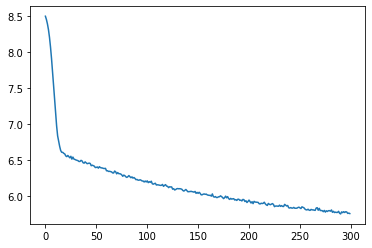

In [7]:
plt.plot(loss_history)

In [5]:
learned_embeddings = model.embedding.weight.data.cpu().numpy()
np.save(EMBEDDINGS_FILE, learned_embeddings) # save

learned_embeddings_dict = {i:learned_embeddings[i] for i, _ in enumerate(learned_embeddings)}
print(f"Shape of embedding (weights): {learned_embeddings.shape}")

Shape of embedding (weights): (5000, 100)


In [6]:
def cosine_similarity(doc1, doc2, bow):
    bow1 = bow[doc1]; bow2 = bow[doc2]
    return np.dot(bow1, bow2)/(np.sqrt(np.dot(bow1, bow1) * np.dot(bow2, bow2)))

for w in ["man", "monday"]:
    similarities = []; word_ids = []
    for w2 in learned_embeddings_dict:
        if np.sum(np.dot(learned_embeddings_dict[w2], learned_embeddings_dict[w2]))==0: pass
        else:
            word_idx = full_dataset.vocab[w]
            similarities.append(cosine_similarity(word_idx, w2, learned_embeddings_dict))
            word_ids.append(w2)
    closest_idx = np.array(word_ids)[np.argsort(similarities)[::-1][1:6]]
    print(f"{w}")
    print(f"\tClosest 5 words: {[list(full_dataset.vocab.keys())[i] for i in closest_idx]}")
    print(f"\tCosine similarities:\t{np.array(similarities)[np.argsort(similarities)[::-1][1:6]]}")
    print("="*50)

man
	Closest 5 words: ['woman', 'teenager', 'boy', '22yearold', 'doctor']
	Cosine similarities:	[0.8390858 0.7929545 0.7653596 0.7119213 0.7073126]
monday
	Closest 5 words: ['thursday', 'wednesday', 'tuesday', 'friday', 'sunday']
	Cosine similarities:	[0.9317715  0.9271284  0.9188106  0.91391313 0.85849553]


# 3. Visualization of bias metrics

Useful package to automatically compute bias metrics:
* automatic computation of the above bias metrics: https://docs.responsibly.ai/notebooks/demo-word-embedding-bias.html

The default pip install does not work.
To make it work:
* pip install gensim==3.7.1
* git clone https://github.com/ResponsiblyAI/responsibly.git
* cd responsibly
* delete the "python_requires" and "install_requires" arguments of responsibly/setup.py
* python setup.py install

In [41]:
from responsibly.we import calc_all_weat

In [43]:
# calc_all_weat(model, filter_by='model', with_original_finding=True,
#               with_pvalue=True, pvalue_kwargs={'method': 'approximate'})